# Tutorial 5: Generalized Oort constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.table import Table, vstack
import glob
from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u
from scipy.optimize import minimize
import emcee
import corner

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In this tutorial, we look at fitting models probabilistically to data. We demonstrate how to use emcee (https://emcee.readthedocs.io) -- an MCMC sampling package. We will use a simple example from the lectures of measuring the Generalized Oort constants (Lecture 4, Slides 25 onwards). In theory, this problem could be analysed using simple linear least-squares. However, that method has a tendency to underestimate uncertainties and for more complex models MCMC is necessary. 

The Oort Constants are related to the averaged proper motions $\mu$ and radial velocities $v_{||}$ across the sky like

\begin{equation}
\begin{split}
\bar{v}_{||}\varpi &= (K+C\cos2\ell+A\sin2\ell)\cos^2b\\
                    &-\varpi(u\cos\ell\cos b+v\sin\ell\cos b+w\sin b),\\
\bar{\mu}_\ell &= (B+A\cos2\ell-C\sin2\ell)\cos^2b\\
&-\varpi(u\sin\ell+v\cos\ell),\\
\bar{\mu}_b &= -(K+C\cos2\ell+A\sin2\ell)\sin b\cos b\\
                &+\varpi(u\cos\ell\sin b+v\sin\ell\sin b-w\cos b).
\end{split}
\end{equation}

$\varpi$ is the parallax, $(u,v,w)$ is the solar peculiar motion, $(K,A,B,C)$ the Oort constants (Here we have ignored the constant $4.74$ that relates proper motions to velocities $v=4.74\mu/\varpi$.

We will use the Gaia RVS sample again, restricting ourselves to nearby main sequence stars.

In [2]:
def read_gaia_rvs(f):
    gaia_rvs_full = pd.read_csv(f)
    fltr = (gaia_rvs_full['parallax']>2.)&(gaia_rvs_full['parallax_over_error']>3.)
    fltr &= (gaia_rvs_full['bp_rp']>0.6)&(gaia_rvs_full['bp_rp']<0.7)
    fltr &= (gaia_rvs_full['phot_g_mean_mag']
                 -5.*np.log10(100./gaia_rvs_full['parallax'])>1.5)
    fltr &= (gaia_rvs_full['phot_g_mean_mag']
                 -5.*np.log10(100./gaia_rvs_full['parallax'])<4.5)
    gaia_rvs = gaia_rvs_full[fltr].reset_index(drop=True)
    return Table.from_pandas(gaia_rvs)
gaia_rvs = vstack([read_gaia_rvs(f) for f in glob.glob('GaiaSource_*.csv')])

We transform to Galactic coordinates -- in particular we require the proper motions in Galactic coordinates. We also complement the catalogue with a `line-of-sight proper motion' i.e. 

$$\mu_\mathrm{los} = \frac{v_\mathrm{los}\varpi}{4.74}$$

In [3]:
PM_Const = 4.74057170372*u.km/u.s*u.yr

s = SkyCoord(ra=gaia_rvs['ra']*u.deg,
             dec=gaia_rvs['dec']*u.deg,
             pm_ra_cosdec=gaia_rvs['pmra']*u.mas/u.yr,
             pm_dec=gaia_rvs['pmdec']*u.mas/u.yr)
gal = s.transform_to(Galactic)

gaia_rvs['pml']=gal.pm_l_cosb
gaia_rvs['pmb']=gal.pm_b
gaia_rvs['pmlos'] = (gaia_rvs['radial_velocity']*u.km/u.s*\
                         gaia_rvs['parallax']*u.mas)*1./PM_Const

First, we correct the proper motions for the solar peculiar motion (we use Schoenrich et al. 2010) using the parallaxes.

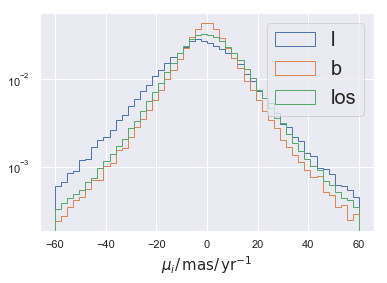

In [4]:
solar_peculiar = np.array([11.1,12.24,7.25])*u.km/u.s

def reflex_velocity(data):
    ''' Reflex velocity in l, b and los'''
    l = np.deg2rad(data['l'])
    b = np.deg2rad(data['b'])

    rv = solar_peculiar[0]*np.sin(l)\
            -solar_peculiar[1]*np.cos(l),\
         solar_peculiar[0]*np.cos(l)*np.sin(b)\
            +solar_peculiar[1]*np.sin(l)*np.sin(b)\
            -solar_peculiar[2]*np.cos(b),\
        -solar_peculiar[0]*np.cos(l)*np.cos(b)\
            -solar_peculiar[1]*np.sin(l)*np.cos(b)\
            -solar_peculiar[2]*np.sin(b)
    return rv

rv = reflex_velocity(gaia_rvs)

for ii,k in enumerate(['l','b','los']):
    gaia_rvs['pm%s_rf'%k]=gaia_rvs['pm%s'%k]\
                    -rv[ii]/PM_Const*gaia_rvs['parallax']*u.mas
    plt.hist(gaia_rvs['pm%s_rf'%k],histtype='step',bins=50,
             range=[-60.,60.],normed=True,label=k);
plt.semilogy()
plt.legend(fontsize=20)
plt.xlabel(r'$\mu_i/\,\mathrm{mas/\,yr}^{-1}$');

We include a further geometric factor in $b$ that relates the velocities and distances to in-plane velocities and distances. Dividing by this factor gives us the mean quantities related to e.g. $K+C\cos2\ell+A\sin2\ell$.

In [5]:
gaia_rvs['pml_rf_g']=gaia_rvs['pml_rf']/np.cos(np.deg2rad(gaia_rvs['b']))**2
gaia_rvs['pmb_rf_g']=gaia_rvs['pmb_rf']/np.cos(np.deg2rad(gaia_rvs['b']))/\
                        np.sin(np.deg2rad(gaia_rvs['b']))
gaia_rvs['pmlos_rf_g']=gaia_rvs['pmlos_rf']/np.cos(np.deg2rad(gaia_rvs['b']))**2

We bin the data in $\ell$ and compute the mean and standard error in each bin. This neglects uncertainties in the proper motions, which we could subtract off using a median error.

Text(0, 0.5, 'Mean proper motion / mas/yr')

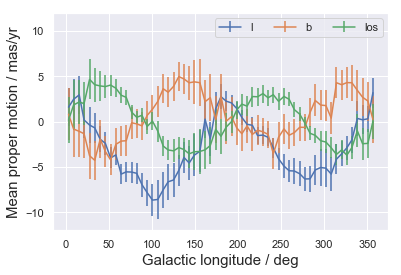

In [6]:
def sdm(x):
    ''' 
        Error in median -- using percentiles as more robust than standard deviation
        Factor is sqrt(pi/2)
    '''
    return 1.253*np.diff(np.percentile(x,[84.,16.]))/np.sqrt(len(x))

## Bin the data and compute means/errors
groups = gaia_rvs[['l','pml_rf_g','pmb_rf_g','pmlos_rf_g']].group_by(
    np.digitize(gaia_rvs['l'],np.linspace(0.,360.,60))
    )
Means = groups.groups.aggregate(np.median)
Errors = groups.groups.aggregate(sdm)

for i in ['l','b','los']:
    plt.errorbar(Means['l'],Means['pm%s_rf_g'%i],Errors['pm%s_rf_g'%i],label=i)
plt.legend(ncol=3)
plt.ylim(-12,12)
plt.xlabel('Galactic longitude / deg')
plt.ylabel('Mean proper motion / mas/yr')

We use a simple model where the likelihood is given by
\begin{equation}
\mathcal{L} = \prod_i \mathcal{N}(\bar{\mu}_i|K_1+K_2\cos2\ell_i+K_3\sin2\ell_i,\sigma_{\mu,i})
\end{equation}
Here the product is over $\ell$ bins and the $\mathcal{N}(x,\mu,\sigma)$ is a Gaussian in $x$ centred on $\mu$ with width $\sigma$. In each $\ell$ bin we have a measurement of the mean proper motion $\bar{\mu}_i$ with uncertainty $\sigma_{\mu,i}$. We know that the mean should follow one of the `Oort functions' which in general look like $K_1+K_2\cos2\ell+K_3\sin2\ell$ where $K_i$ are different depending on which component we consider. Taking the logarithm we find
\begin{equation}
\log\mathcal{L} = -\sum_i \frac{(\bar{\mu}_i-(K_1+K_2\cos2\ell_i+K_3\sin2\ell_i))^2}{2\sigma_{\mu,i}^2}
\end{equation}
where we have ignored the constant normalization term.

We define the log-likelihood function

In [7]:
def lnL(p,l,data,invvar):
    ''' l in rad, 
        data=mean proper motion (reflex and geometry corrected), 
        invvar = inverse variance of measurements'''
    K1,K2,K3 = p[0],p[1],p[2]
    OortFn = K1 + K2*np.cos(2.*l) + K3*np.sin(2.*l)
    return -5.*np.sum(invvar*(data-OortFn)**2)

And set up a function to sample. We find an initial guess of the parameters using the minimize function in scipy.optimize.

In [8]:
def run_sampler(column, nwalkers=50, nsamples=100):
    ''' Run model on column data -- use nwalkers, run nsamples where half are burn-in'''
    ndim = 3

    # Set up data
    l = np.deg2rad(Means['l'])
    data = Means[column+'_rf_g']
    invvar = 1. / Errors[column+'_rf_g']**2
    
    ## Initialize walkers using the maximum likelihood solution
    optimum = minimize(lambda x: -lnL(x,l,data,invvar),
                       np.array([-12.,15.,3.])/PM_Const.value).x
    print('Minimum found at',optimum*PM_Const.value)
    p0 = np.array([np.random.normal(loc=optimum,
                                    scale=.01*np.ones(ndim),
                                    size=ndim) 
                   for i in range(nwalkers)])
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL, 
                                    args=[l,data,invvar],threads=4)
    sampler.run_mcmc(p0, nsamples)
    
    return sampler.flatchain[-int(nsamples*nwalkers/2):,:]

Run the samples and generate the standard corner plots. Here the constants are in units of proper motion (mas/yr).

Minimum found at [ 0.14542286 -2.45276189 16.1854335 ]
Minimum found at [-13.64419249  19.22829198   6.98550693]
Minimum found at [  2.73091762   2.81328797 -15.19090281]


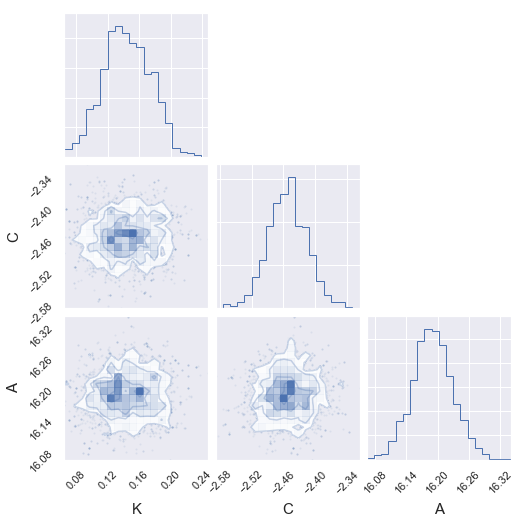

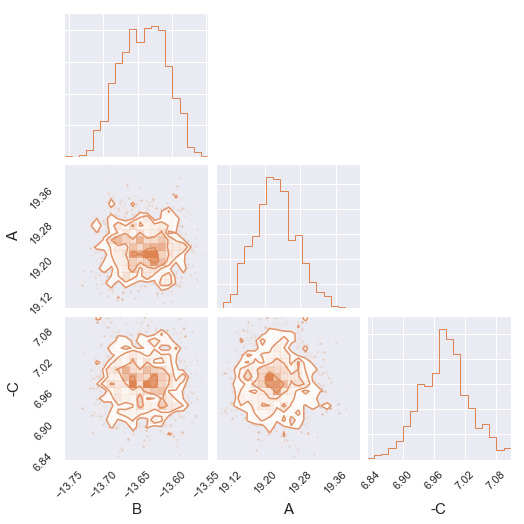

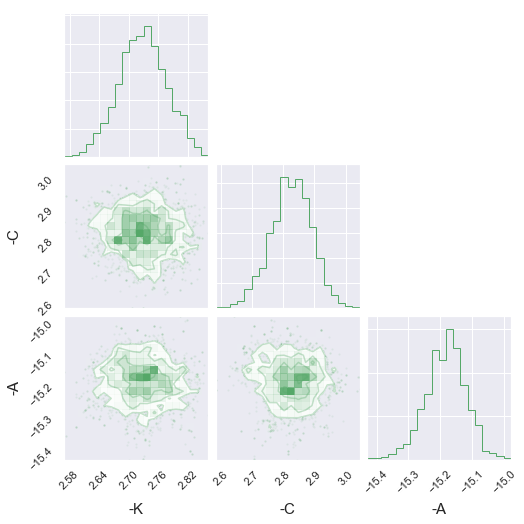

In [9]:
samplesLOS = run_sampler('pmlos',nsamples=150,nwalkers=50)

samplesL = run_sampler('pml',nsamples=150,nwalkers=50)

samplesB = run_sampler('pmb',nsamples=150,nwalkers=50)

corner.corner(samplesLOS*PM_Const.value,color=sns.color_palette()[0],
              labels=['K','C','A']);
corner.corner(samplesL*PM_Const.value,color=sns.color_palette()[1],
              labels=['B','A','-C']);
corner.corner(samplesB*PM_Const.value,color=sns.color_palette()[2],
              labels=['-K','-C','-A']);

In [10]:
def plot_models(samples,N=10):
    for i in np.random.randint(0,len(samples),N):
        plt.plot(Means['l'],samples[i,0]+
                 samples[i,1]*np.cos(2.*np.deg2rad(Means['l']))+
                 samples[i,2]*np.sin(2.*np.deg2rad(Means['l'])),
                 color=sns.color_palette()[0],
                 alpha=0.5)

We compare the models to the data. We have plotted many samples from the model, although you cannot tell. The formal uncertainty in the parameters is very small.

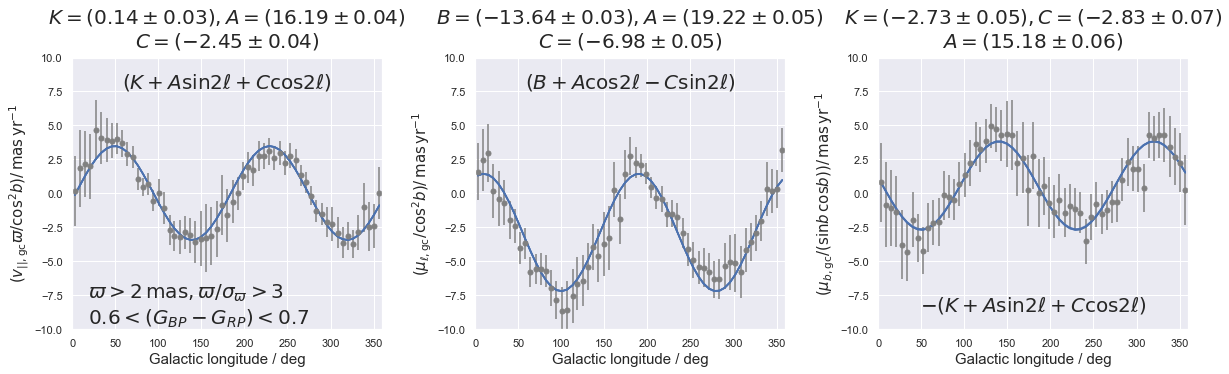

In [11]:
f,a=plt.subplots(1,3,figsize=[20.,5.])
plt.subplots_adjust(wspace=0.3)

plt.sca(a[0])
plt.annotate(r'$\varpi>2\,\mathrm{mas}, \varpi/\sigma_\varpi>3$'+'\n'
             +r'$0.6<(G_{BP}-G_{RP})<0.7$',
             xy=(0.05,0.),xycoords='axes fraction', fontsize=20, 
             ha='left', va='bottom')

for i,K in enumerate(['pmlos','pml','pmb']):
    a[i].errorbar(Means['l'],Means['%s_rf_g'%K],Errors['%s_rf_g'%K],
                  fmt='o',ms=5,color='grey');

plt.sca(a[0])
plot_models(samplesLOS)
plt.ylabel(r'$(v_{||,\mathrm{gc}}\varpi/\cos^2b)/\,\mathrm{mas\,yr^{-1}}$')
plt.annotate(r'$(K+A\sin2\ell+C\cos2\ell)$',xy=(0.5,0.95),xycoords='axes fraction',
             fontsize=20,ha='center',va='top')
plt.annotate(r'$K=(%0.2f\pm%0.2f),$'%(np.median(samplesLOS[:,0]*PM_Const.value),
                                      np.std(samplesLOS[:,0]*PM_Const.value))
            +r'$A=(%0.2f\pm%0.2f)$'%(np.median(samplesLOS[:,2]*PM_Const.value),
                                     np.std(samplesLOS[:,2]*PM_Const.value))
             +'\n'+r'$C=(%0.2f\pm%0.2f)$'%(np.median(samplesLOS[:,1]*PM_Const.value),
                                           np.std(samplesLOS[:,1]*PM_Const.value)),
             xy=(0.5,1.02),xycoords='axes fraction',
             fontsize=20,ha='center',va='bottom')

plt.sca(a[1])
plot_models(samplesL)
plt.ylabel(r'$(\mu_{\ell,\mathrm{gc}}/\cos^2b)/\,\mathrm{mas\,yr^{-1}}$')
plt.annotate(r'$(B+A\cos2\ell-C\sin2\ell)$',xy=(0.5,0.95),xycoords='axes fraction',
             fontsize=20,ha='center',va='top')
plt.annotate(r'$B=(%0.2f\pm%0.2f),$'%(np.median(samplesL[:,0]*PM_Const.value),
                                      np.std(samplesL[:,0]*PM_Const.value))
            +r'$A=(%0.2f\pm%0.2f)$'%(np.median(samplesL[:,1]*PM_Const.value),
                                     np.std(samplesL[:,1]*PM_Const.value))
             +'\n'+r'$C=(%0.2f\pm%0.2f)$'%(np.median(-samplesL[:,2]*PM_Const.value),
                                           np.std(samplesL[:,2]*PM_Const.value)),
             xy=(0.5,1.02),xycoords='axes fraction',
             fontsize=20,ha='center',va='bottom')

plt.sca(a[2])
plot_models(samplesB)
plt.ylabel(r'$(\mu_{b,\mathrm{gc}}/(\sin b\,\cos b))/\,\mathrm{mas\,yr^{-1}}$')
plt.annotate(r'$-(K+A\sin2\ell+C\cos2\ell)$',xy=(0.5,0.05),
             xycoords='axes fraction',fontsize=20,ha='center',va='bottom')
plt.annotate(r'$K=(%0.2f\pm%0.2f),$'%(np.median(-samplesB[:,0]*PM_Const.value),
                                      np.std(-samplesB[:,0]*PM_Const.value))
            +r'$C=(%0.2f\pm%0.2f)$'%(np.median(-samplesB[:,1]*PM_Const.value),
                                     np.std(-samplesB[:,1]*PM_Const.value))
             +'\n'+r'$A=(%0.2f\pm%0.2f)$'%(np.median(-samplesB[:,2]*PM_Const.value),
                                           np.std(-samplesB[:,2]*PM_Const.value)),
             xy=(0.5,1.02),xycoords='axes fraction',
             fontsize=20,ha='center',va='bottom')
for ii in range(3):
    plt.sca(a[ii])
    plt.xlabel(r'Galactic longitude / deg')
    plt.xlim(0.,360.)
    plt.ylim(-10.,10.)

Things to do next (e.g. Bovy 2017 with TGAS data):

1. Consider the (correlated) uncertainties in the observables.
2. Repeat calculation for different stellar populations.